In [1]:
from torch_geometric.data import HeteroData
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = HeteroData()

In [3]:
data

HeteroData()

In [4]:
x_highres = torch.arange(0.1,10,0.2)
y_highres = torch.arange(0.1,10,0.2)
x_lowres = torch.arange(0,11,1)
y_lowres = torch.arange(0,11,1)
x_highres_lowres = torch.cat((x_highres, x_lowres),dim=0)
y_highres_lowres = torch.cat((y_highres, y_lowres),dim=0)
x_highres_lowres, _ = torch.sort(x_highres_lowres)
y_highres_lowres, _ = torch.sort(y_highres_lowres)

x_highres_mesh, y_highres_mesh = torch.meshgrid(x_highres, y_highres, indexing='ij')
x_lowres_mesh, y_lowres_mesh = torch.meshgrid(x_lowres, y_lowres, indexing='ij')
x_highres_lowres_mesh, y_highres_lowres_mesh = torch.meshgrid(x_highres_lowres, y_highres_lowres, indexing='ij')

In [5]:
x_highres_lowres

tensor([ 0.0000,  0.1000,  0.3000,  0.5000,  0.7000,  0.9000,  1.0000,  1.1000,
         1.3000,  1.5000,  1.7000,  1.9000,  2.0000,  2.1000,  2.3000,  2.5000,
         2.7000,  2.9000,  3.0000,  3.1000,  3.3000,  3.5000,  3.7000,  3.9000,
         4.0000,  4.1000,  4.3000,  4.5000,  4.7000,  4.9000,  5.0000,  5.1000,
         5.3000,  5.5000,  5.7000,  5.9000,  6.0000,  6.1000,  6.3000,  6.5000,
         6.7000,  6.9000,  7.0000,  7.1000,  7.3000,  7.5000,  7.7000,  7.9000,
         8.0000,  8.1000,  8.3000,  8.5000,  8.7000,  8.9000,  9.0000,  9.1000,
         9.3000,  9.5000,  9.7000,  9.9000, 10.0000])

In [6]:
x_highres_lowres_mesh.shape

torch.Size([61, 61])

In [7]:
low_res_nodes = np.logical_and(np.in1d(x_highres_lowres_mesh.flatten(), x_lowres_mesh.flatten()),
                               np.in1d(y_highres_lowres_mesh.flatten(), y_lowres_mesh.flatten())) 

In [8]:
low_res_nodes.sum()

121

In [9]:
x_highres_lowres_mesh.flatten()[low_res_nodes]

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
         3.,  3.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  5.,
         5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  6.,  6.,  6.,  6.,
         6.,  6.,  6.,  6.,  6.,  6.,  6.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,
         7.,  7.,  7.,  7.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
         8.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10.])

In [10]:
y_highres_lowres_mesh.flatten()[low_res_nodes]

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.,  0.,  1.,  2.,
         3.,  4.,  5.,  6.,  7.,  8.,  9., 10.,  0.,  1.,  2.,  3.,  4.,  5.,
         6.,  7.,  8.,  9., 10.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,
         9., 10.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.,  0.,
         1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.,  0.,  1.,  2.,  3.,
         4.,  5.,  6.,  7.,  8.,  9., 10.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,
         7.,  8.,  9., 10.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.,
        10.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.,  0.,  1.,
         2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [11]:
high_res_nodes = np.logical_and(np.in1d(x_highres_lowres_mesh.flatten(), x_highres_mesh.flatten()),
                               np.in1d(y_highres_lowres_mesh.flatten(), y_highres_mesh.flatten())) 

In [12]:
high_res_nodes.sum()

2500

In [13]:
x_highres_mesh.shape

torch.Size([50, 50])

In [14]:
edge_index_highres = np.empty((2,0), dtype=int)
LON_DIFF_MAX = 0.21
LAT_DIFF_MAX = 0.21

for ii, xi in enumerate(torch.concatenate((x_highres_mesh.flatten().unsqueeze(-1),
                                           y_highres_mesh.flatten().unsqueeze(-1)),dim=-1)):
    bool_lon = abs(x_highres_mesh.flatten() - xi[0]) < LON_DIFF_MAX
    bool_lat = abs(y_highres_mesh.flatten() - xi[1]) < LAT_DIFF_MAX
    bool_both = np.logical_and(bool_lon, bool_lat).bool()
    jj_list = np.flatnonzero(bool_both)
    xj_list = y_highres_mesh.flatten()[bool_both]
    for jj, xj in zip(jj_list, xj_list):
        if not np.array_equal(xi, xj):
            edge_index_highres = np.concatenate((edge_index_highres, np.array([[ii], [jj]])), axis=-1, dtype=int)
    #write_log(f"\nStart node: {xi} - done. Node has {n_neighbours} neighbours.", args)

edge_index_highres = edge_index_highres.swapaxes(0,1)

In [15]:
edge_index_lowres = np.empty((2,0), dtype=int)
LON_DIFF_MAX = 1.1
LAT_DIFF_MAX = 1.1

for ii, xi in enumerate(torch.concatenate((x_lowres_mesh.flatten().unsqueeze(-1),
                                           y_lowres_mesh.flatten().unsqueeze(-1)),dim=-1)):
    
    bool_lon = abs(x_lowres_mesh.flatten() - xi[0]) < LON_DIFF_MAX
    bool_lat = abs(y_lowres_mesh.flatten() - xi[1]) < LAT_DIFF_MAX
    bool_both = np.logical_and(bool_lon, bool_lat).bool()
    jj_list = np.flatnonzero(bool_both)
    xj_list = y_lowres_mesh.flatten()[bool_both]
    for jj, xj in zip(jj_list, xj_list):
        if not np.array_equal(xi, xj):
            edge_index_lowres = np.concatenate((edge_index_lowres, np.array([[ii], [jj]])), axis=-1, dtype=int)
    #write_log(f"\nStart node: {xi} - done. Node has {n_neighbours} neighbours.", args)

edge_index_lowres = edge_index_lowres.swapaxes(0,1)

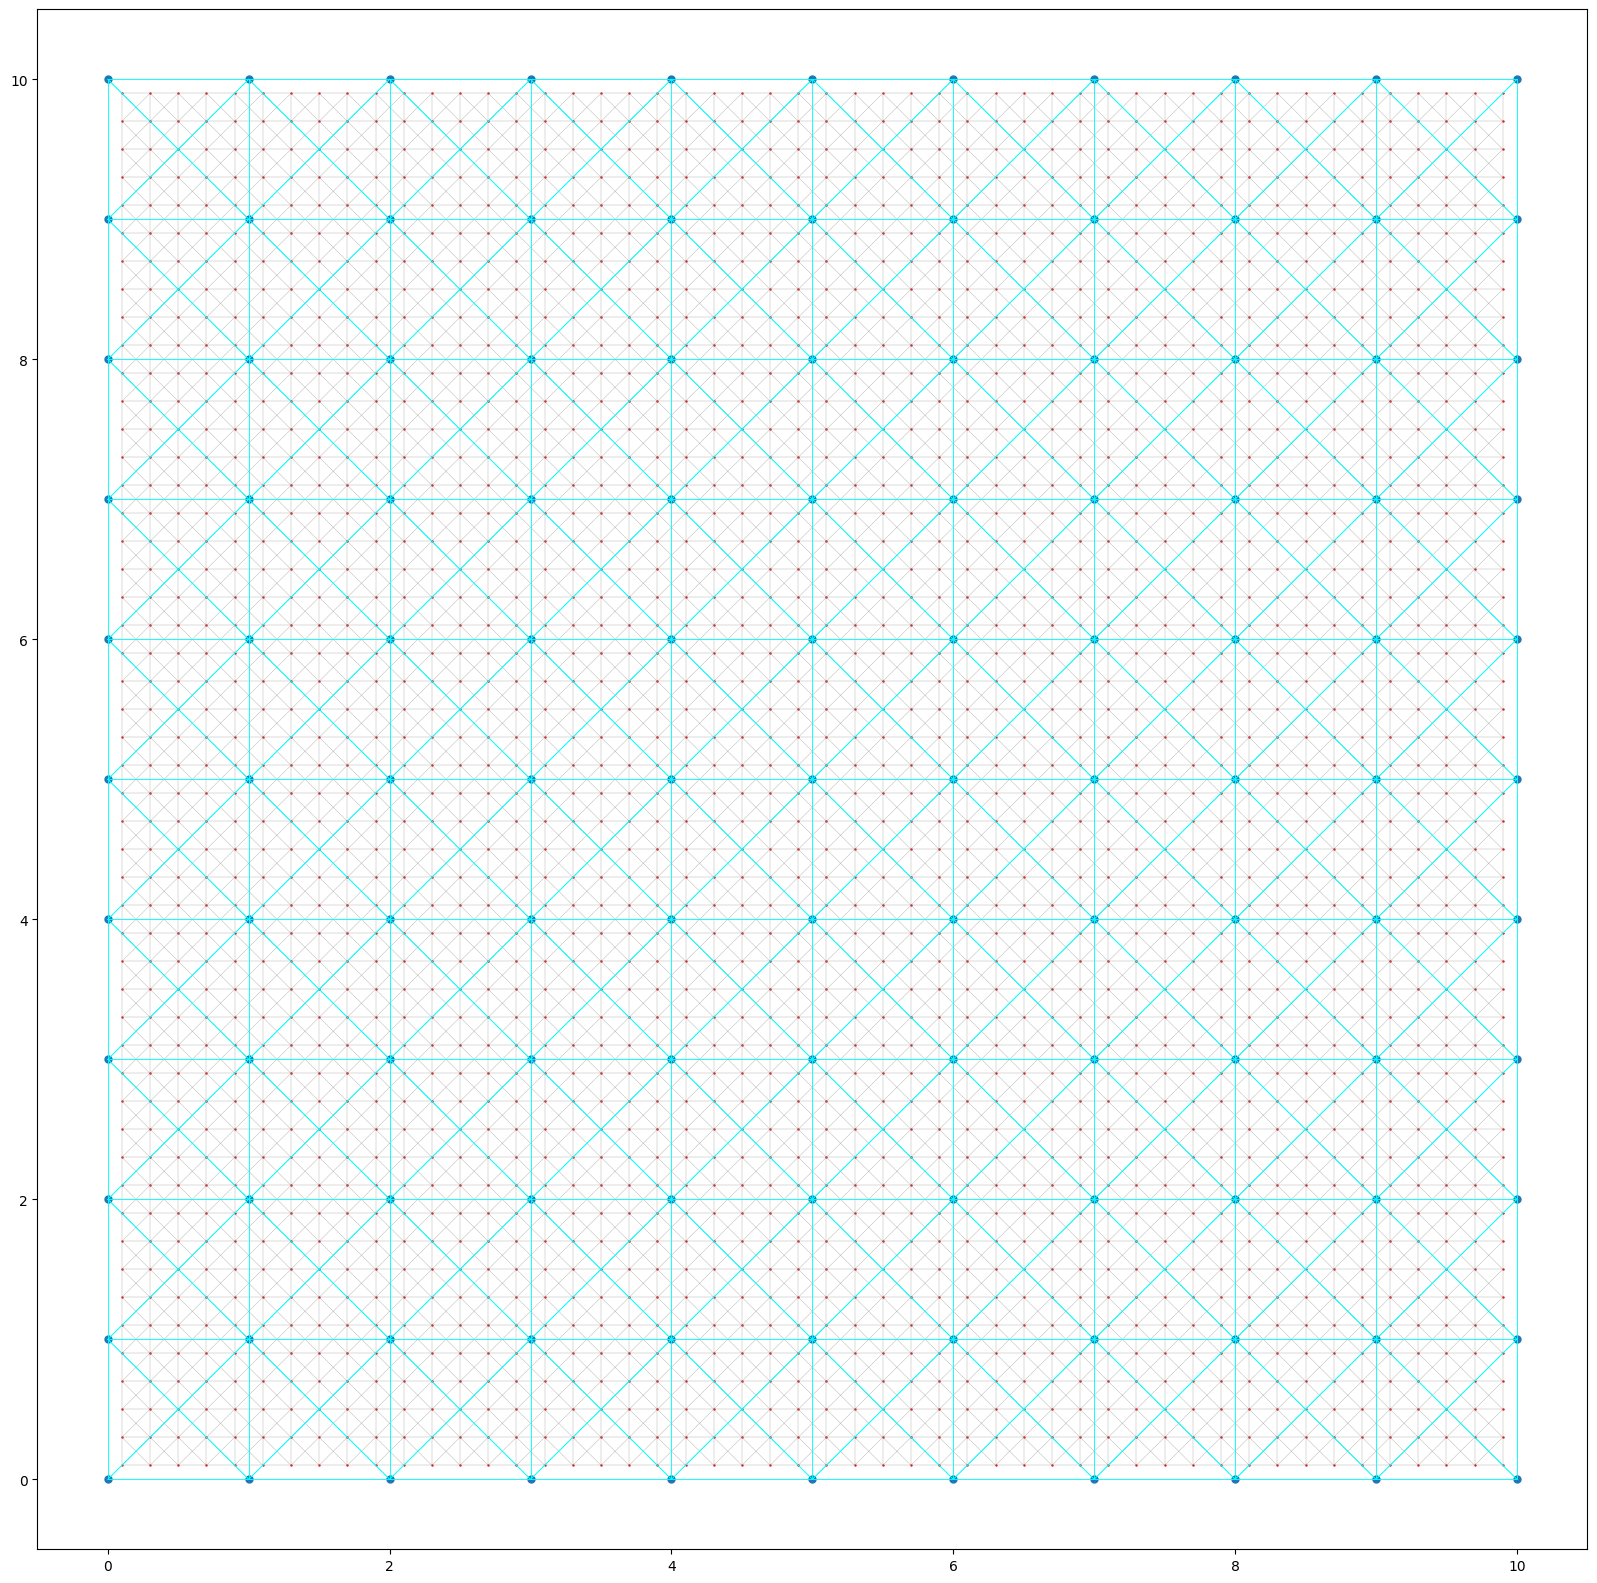

In [16]:
fig, ax = plt.subplots(figsize=(20,20))

for edge in edge_index_highres:
    n1 = edge[0]
    n2 = edge[1]
    ax.plot([x_highres_mesh.flatten()[n1], x_highres_mesh.flatten()[n2]], [y_highres_mesh.flatten()[n1],y_highres_mesh.flatten()[n2]],
            linewidth=0.1, c='grey')
    
for edge in edge_index_lowres:
    n1 = edge[0]
    n2 = edge[1]
    ax.plot([x_lowres_mesh.flatten()[n1], x_lowres_mesh.flatten()[n2]], [y_lowres_mesh.flatten()[n1],y_lowres_mesh.flatten()[n2]],
            linewidth=0.5, c='cyan')
    
ax.scatter(x_lowres_mesh.flatten(), y_lowres_mesh.flatten(), s=25)
ax.scatter(x_highres_mesh.flatten(), y_highres_mesh.flatten(), s=0.5, c='r')
plt.show()

In [19]:
edge_index_lowres_to_highres = np.empty((2,0), dtype=int)
LON_DIFF_MAX = 0.5
LAT_DIFF_MAX = 0.5

xy = torch.concatenate((x_highres_lowres_mesh.flatten().unsqueeze(-1), y_highres_lowres_mesh.flatten().unsqueeze(-1)),dim=-1)

for ii, xi in enumerate(xy):
    if low_res_nodes[ii]:
        # print(ii, ": yes!")
        bool_lon = abs(x_highres_lowres_mesh.flatten() - xi[0]) < LON_DIFF_MAX
        bool_lat = abs(y_highres_lowres_mesh.flatten() - xi[1]) < LAT_DIFF_MAX
        bool_both = np.logical_and(bool_lon, bool_lat).bool() * torch.tensor(high_res_nodes).bool()
        jj_list = np.flatnonzero(bool_both)
        xj_list = xy[bool_both,:]
        for jj, xj in zip(jj_list, xj_list):
            if high_res_nodes[jj]:
                if not np.array_equal(xi, xj):
                    edge_index_lowres_to_highres = np.concatenate((edge_index_lowres_to_highres, np.array([[ii], [jj]])), axis=-1, dtype=int)
        #write_log(f"\nStart node: {xi} - done. Node has {n_neighbours} neighbours.", args)

edge_index_lowres_to_highres = edge_index_lowres_to_highres.swapaxes(0,1)

In [20]:
edge_index_lowres_to_highres.shape

(1600, 2)

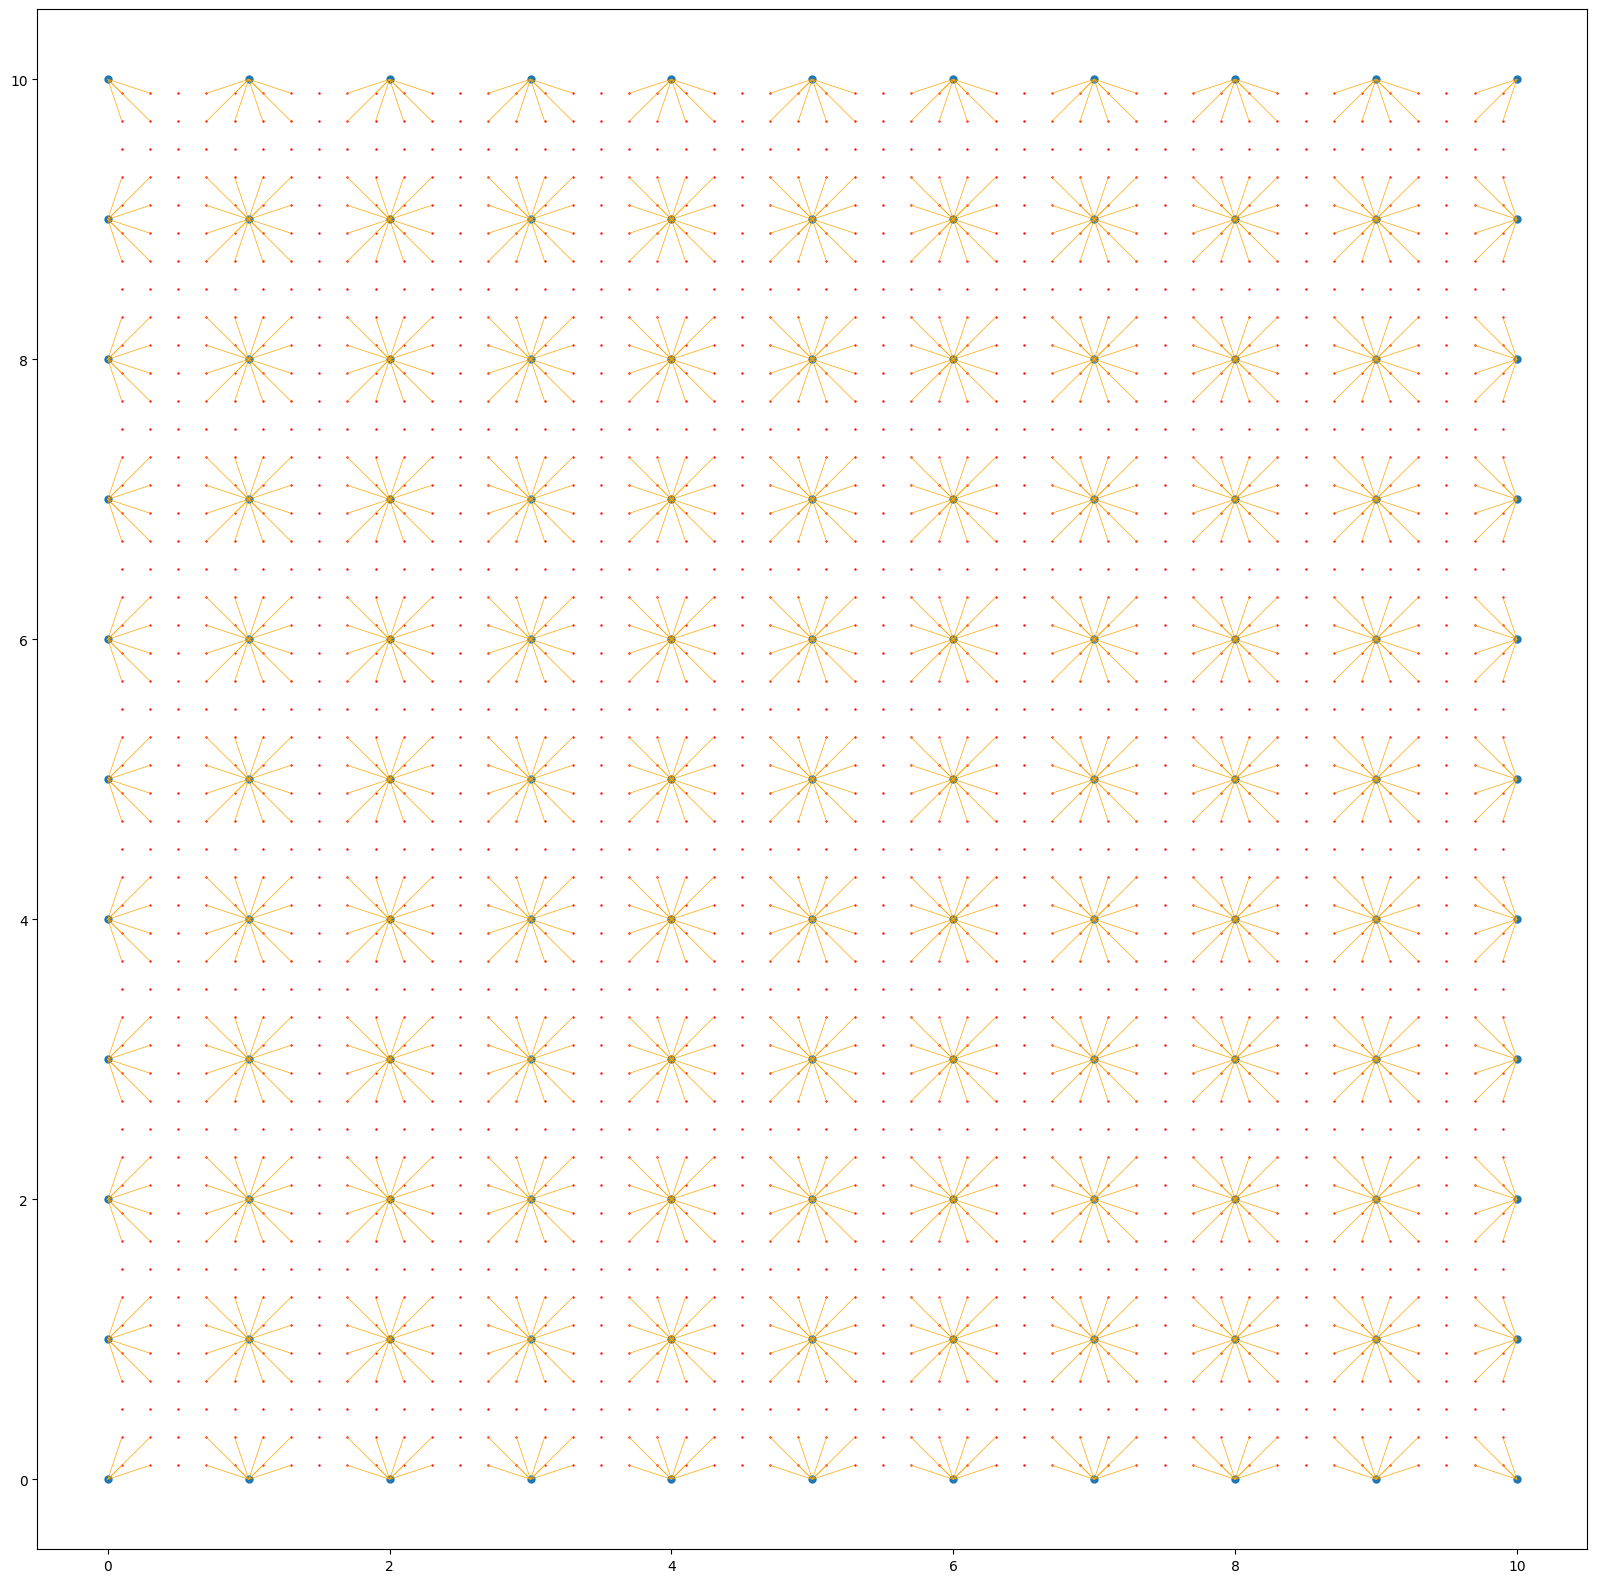

In [21]:
fig, ax = plt.subplots(figsize=(20,20))

# for edge in edge_index_highres:
#     n1 = edge[0]
#     n2 = edge[1]
#     ax.plot([x_highres_mesh.flatten()[n1], x_highres_mesh.flatten()[n2]], [y_highres_mesh.flatten()[n1],y_highres_mesh.flatten()[n2]],
#             linewidth=0.1, c='grey')
    
# for edge in edge_index_lowres:
#     n1 = edge[0]
#     n2 = edge[1]
#     ax.plot([x_lowres_mesh.flatten()[n1], x_lowres_mesh.flatten()[n2]], [y_lowres_mesh.flatten()[n1],y_lowres_mesh.flatten()[n2]],
#             linewidth=0.5, c='cyan')

for edge in edge_index_lowres_to_highres:
    n1 = edge[0]
    n2 = edge[1]
    ax.plot([x_highres_lowres_mesh.flatten()[n1], x_highres_lowres_mesh.flatten()[n2]],
            [y_highres_lowres_mesh.flatten()[n1], y_highres_lowres_mesh.flatten()[n2]],
            linewidth=0.5, c='orange')

ax.scatter(x_lowres_mesh.flatten(), y_lowres_mesh.flatten(), s=25)
ax.scatter(x_highres_mesh.flatten(), y_highres_mesh.flatten(), s=0.5, c='r')
plt.show()

In [22]:
n2, x_highres_lowres_mesh.flatten()[52]

(3658, tensor(0.))

In [ ]:
data['highres'].x = 